In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from traitlets import traitlets
from IPython.display import display, Markdown
from ipywidgets import HBox, VBox, BoundedFloatText, BoundedIntText, Text, Layout, Button

# Setting up model variables

In [4]:
style = {'description_width': 'initial'}

# estimated incidence rate world-wide (0.38 per 100,000 per year) [https://doi.org/10.1002/mds.25075]
est_inc_rate_text = BoundedFloatText(
    min=0.25,
    max=0.45,
    step=0.05,
    value=0.38,
    description='Incidence rate (world per 100.000):', style=style)

# actual incidence rate (0.56 per 100,000 per year) ~ 3 new HD patients in Muscat in 2018 [https://data.gov.om/OMPOP2016/population?indicator=1000140&region=1000020-muscat&nationality=1000010-omani]
act_inc_rate_text = BoundedFloatText(
    min=0.45,
    max=0.65,
    step=0.05,
    value=0.56,
    description='Incidence rate (oman per 100.000):', style=style)

# estimated death rates as for England-Wales in 1960-1973 were 1.55 per million population
# http://europepmc.org/backend/ptpmcrender.fcgi?accid=PMC1684448&blobtype=pdf
est_death_rate_text = BoundedFloatText(
    description='Death rate (world per 100.000):', 
    style=style,
    min=0.12,
    max=0.18,
    step=0.005,
    value=0.155
)

# actual death rate ~ 1 patient in 2018 per 100.000 per year in Muscat
act_death_rate_text = BoundedFloatText(
    min=0.16,
    max=0.2,
    step=0.01,
    value=0.1819,
    description='Death rate (oman per 100.000):', style=style)

# starting HD population in Muscat in 2014 (32)
hd_2014_text = BoundedIntText(
    min=0,
    max=1000,
    step=1,
    value=32,
    description='HD population in Muscat in 2014:', style=style,
    layout=Layout(height='50px'))

simulation_end_text = BoundedIntText(
    min=2015,
    max=2100,
    step=1,
    value=2050,
    description='Simulate from 2014 until:', style=style)

class GenerateTimeButton(Button):
    """A button that can holds a value as a attribute."""

    def __init__(self, value=None, *args, **kwargs):
        super(GenerateTimeButton, self).__init__(*args, **kwargs)
        # Create the value attribute.
        self.add_traits(value=traitlets.Any(value))
        
# Generate time period (list of years) to be simulated
def on_generate_time_button_clicked(x_new):
    x_new.value = np.arange(2014, simulation_end_text.value+1, 1).reshape((-1, 1))
    print("Simulation time points generated")

generate_time_button = GenerateTimeButton(
    description="Generate",
    button_style='info',
    tooltip='Generate simulation time points'
)
generate_time_button.on_click(on_generate_time_button_clicked)

hbox_time = HBox([simulation_end_text, generate_time_button])
left_box = VBox([est_inc_rate_text, act_inc_rate_text, hd_2014_text, hbox_time])
right_box = VBox([est_death_rate_text, act_death_rate_text])
hbox = HBox([left_box, right_box])

display(hbox)

Simulation time points generated


# Load demographic data

Demographic data must be formatted in a file with two columns.<br>
The __first__ column must contain _years_.<br>
The __second__ column, which must be named *Population*, must contain integer numbers, which are the total populations in Muscat per year

In [5]:
class LoadDataFrameButton(Button):
    """A button that can holds a value as a attribute."""

    def __init__(self, value=None, *args, **kwargs):
        super(LoadDataFrameButton, self).__init__(*args, **kwargs)
        # Create the value attribute.
        self.add_traits(value=traitlets.Any(value))

def on_load_button_clicked(dframe):
    dframe.value = pd.read_csv(demographics_text.value, sep='\t', index_col=0)
    print(dframe.value)

# Set a text field where to specify the dataset's URL
demographics_text = Text(
    placeholder='Type something',
    value="https://www.dropbox.com/s/iraodt9soiujtqk/Epidemiology_Oman.txt?dl=1",
    description='Demographic data URL:', style=style,
    layout=Layout(width='600px', height='50px'))

load_button = LoadDataFrameButton(
    description="Load data",
    button_style='info',
    tooltip='Load demographic data'
)
df = load_button.on_click(on_load_button_clicked)

hbox_demo = HBox([demographics_text, load_button])
display(hbox_demo)

      Population
Year            
2010      407006
2011      418652
2012      435149
2013      451652
2014      470085
2015      487592
2016      512039
2017      528327
2018      543930


### Save data collected by *on_click* events og buttons into variables

In [6]:
df = load_button.value
x_new = generate_time_button.value

# Predict population until {{simulation_end_text.value}}

coefficient of determination: 0.996
intercept: -35324154.9
slope: [17774.017]

time:				[2010 2011 2012 2013 2014 2015 2016 2017 2018]
predicted response:		[401619. 419393. 437167. 454941. 472715. 490489. 508263. 526037. 543811.]
predicted response [2019]	579359.0
actual data [2019]:		567851


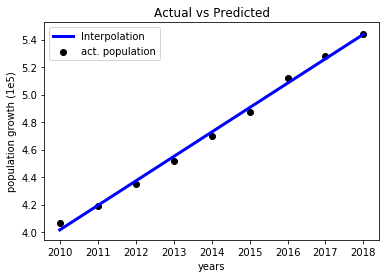

In [7]:
%matplotlib inline

x = df.index.values.reshape((-1, 1))
y = df.Population
model = LinearRegression().fit(x, y)

r_sq = model.score(x, y)
print('coefficient of determination:', np.round(r_sq, 3))
print('intercept:', np.round(model.intercept_, 3))
print('slope:', np.round(model.coef_, 3))
print('')

# Predict response of known data
y_pred = model.predict(x)
print('time:', np.transpose(x)[0], sep='\t\t\t\t')
print('predicted response:', np.around(y_pred), sep='\t\t')

# Plot outputs
axis_scale = 1e5
plt.scatter(x, y/axis_scale,  color='black', label="act. population")
plt.plot(x, y_pred/axis_scale, color='blue',
         linewidth=3, label="Interpolation")

plt.title('Actual vs Predicted')
plt.xlabel('years')
plt.ylabel('population growth (1e5)')

plt.legend(loc='upper left')

# Predict response of future data [2019]
y_pred = np.round(model.predict(x_new))
print('predicted response [2019]', y_pred[6], sep='\t')
print('actual data [2019]:\t\t{}'.format(567851))

### Set the number of simulation traces

In [8]:
simulation_traces = BoundedIntText(
    min=1,
    max=5000,
    step=1,
    value=1000,
    description='Simulation traces:', style=style)
display(simulation_traces)

BoundedIntText(value=1000, description='Simulation traces:', max=5000, min=1, style=DescriptionStyle(descripti…

### Initialize state vectors

In [9]:
sim_time = len(x_new)

# simulation traces
num_traces = simulation_traces.value

# est_inc = np.zeros(sim_time)
est_inc = np.zeros((num_traces, sim_time), dtype=int)
act_inc = np.zeros((num_traces, sim_time), dtype=int)

est_death = np.zeros((num_traces, sim_time), dtype=int)
act_death = np.zeros((num_traces, sim_time), dtype=int)

est_alive_HD = np.zeros((num_traces, sim_time), dtype=int)
est_alive_HD[:, 0] = hd_2014_text.value
act_alive_HD = np.zeros((num_traces, sim_time), dtype=int)
act_alive_HD[:, 0] = hd_2014_text.value

### Trigger the simulation loop

In [10]:
for rep in range(num_traces):
    for t in range(sim_time-1):
        curr_pop = y_pred[t]

        est_inc[rep, t] = np.random.poisson(
            (est_inc_rate_text.value * curr_pop)/100000)
        act_inc[rep, t] = np.random.poisson(
            (act_inc_rate_text.value * curr_pop)/100000)

        est_death[rep, t] = np.random.poisson(
            (est_death_rate_text.value * curr_pop)/100000)
        act_death[rep, t] = np.random.poisson(
            (act_death_rate_text.value * curr_pop)/100000)

        est_alive_HD[rep, t+1] = est_alive_HD[rep, t] - \
            est_death[rep, t] + est_inc[rep, t]
        act_alive_HD[rep, t+1] = act_alive_HD[rep, t] - \
            act_death[rep, t] + act_inc[rep, t]

### Plot HD population predicted to be alive in Muscat

N.b., __est. HD population__ accounts for the population that is predicted to be alive every year according to *incidence* and *death* rates that are the world average. __act. HD population__ refers instead to actual rates calculated stright on the actual Muscat population records.

Button(button_style='info', description='Save SVG', style=ButtonStyle(), tooltip='Save to SVG file')

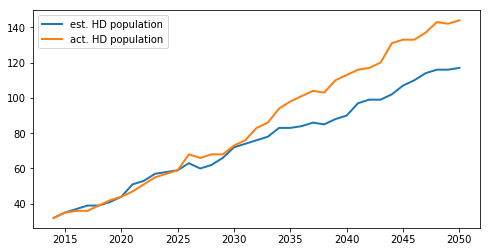

In [25]:
# Select a random trace
rtrace = np.random.randint(0,num_traces)

# Plot a random trace of est/act. alive HD cases in Muscat area
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(x_new, est_alive_HD[rtrace, :], lw=2, label='est. HD population')
ax.plot(x_new, act_alive_HD[rtrace, :], lw=2, label='act. HD population')
ax.legend(loc='upper left')

def on_save_alive_pop_button(but):
    fig.savefig('alive_population.svg', format='svg', dpi=1200)
    print('Figure saved')

save_alive_button = Button(
    description="Save SVG",
    button_style='info',
    tooltip='Save to SVG file'
)
save_alive_button.on_click(on_save_alive_pop_button)
display(save_alive_button)

# Calculate prevalence until {{simulation_end_text.value}}

In [12]:
# Calculate prevalence until 2050
prev_HD = np.round((act_alive_HD / y_pred)*1e5, 2)
print(prev_HD)

[[ 6.77  6.73  7.67 ... 10.86 10.96 10.97]
 [ 6.77  7.14  6.89 ... 10.49 10.96 11.59]
 [ 6.77  6.32  6.69 ... 13.37 13.98 14.38]
 ...
 [ 6.77  7.14  7.08 ... 11.79 12.06 11.86]
 [ 6.77  7.14  7.08 ... 12.16 12.33 12.58]
 [ 6.77  6.73  6.89 ... 10.86 10.87 11.06]]


### Plot the actual HD prevalence in the Muscat area

Button(button_style='info', description='Save SVG', style=ButtonStyle(), tooltip='Save to SVG file')

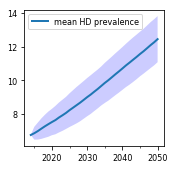

Figure saved


In [44]:
# calculate average and standard deviation of prevalence data over all traces
mu = prev_HD.mean(axis=0)
sigma = prev_HD.std(axis=0)

# instantiate and configure the final plot
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))
ax.plot(x_new, prev_HD.mean(axis=0), lw=2, label='mean HD prevalence')
ax.legend(loc='upper left')
ax.set_xticks([2015, 2025, 2035, 2045], minor=True)
ax.fill_between(x_new.flatten(), mu+sigma, mu-sigma, facecolor='blue', alpha=0.2)
# plt.rcParams.update({'font.size': 10})

def on_save_prevalence_button(but):
    fig.savefig('act_prevalence.svg', format='svg', dpi=1200)
    print('Figure saved')

save_prevalence_button = Button(
    description="Save SVG",
    button_style='info',
    tooltip='Save to SVG file'
)
save_prevalence_button.on_click(on_save_prevalence_button)
display(save_prevalence_button)

### Generate a prevalence table

In [14]:
prev_df = pd.DataFrame({'Years':x_new.flatten(), 'Prevalence':mu})
print(prev_df.head())

def on_save_prevalence_table_button(but):
    prev_df.to_excel("prevalence_table.xlsx", index=False)  
    print('Figure saved')

save_prevalence_table_button = Button(
    description="Save XLSX",
    button_style='info',
    tooltip='Save to Excel file'
)
save_prevalence_table_button.on_click(on_save_prevalence_table_button)
display(save_prevalence_table_button)

   Years  Prevalence
0   2014     6.77000
1   2015     6.87476
2   2016     7.00071
3   2017     7.14400
4   2018     7.28305


Button(button_style='info', description='Save XLSX', style=ButtonStyle(), tooltip='Save to Excel file')

Figure saved


# Print system and required packages information

In [74]:
%load_ext watermark
%watermark -v -m -p numpy,pandas,matplotlib,sklearn,traitlets,IPython,ipywidgets

# date
print(" ")
%watermark -u -n -t -z

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
CPython 3.6.4
IPython 7.8.0

numpy 1.14.3
pandas 0.25.1
matplotlib 2.2.3
sklearn 0.20.3
traitlets 4.3.2
IPython 7.8.0
ipywidgets 7.5.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 60 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
 
last updated: Fri Mar 06 2020 21:18:44 W. Europe Standard Time
